# Sewer network example

This example demonstrates the use of pysewer to generate a sewer network using the the following data inputs:
- A digital elevation model (DEM)
- Road network data
- Building footprint data

In this example the road and building data are generated using the [OSMnx] package.

The network is generated using the following steps:
1. Preprocessing of the input data. This involves setting input parameters and converting the input data to the correct format. This is then followed by instantiation of the network using pysewer.ModelDomain
2. Application of the routing algorithm to generate the sewer network. This is done using repeated shortest path heuristic (RSPH) algorithm. This is done using pysewer.rsph_tree ()
3. Hydraulic calculations and pump optimization 
4. Post processing of the results
5. Export of the generated sewer network to a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.

## Preprocessing


In [1]:
import pysewer
import matplotlib.pyplot as plt
import networkx as nx
from pysewer.config.settings import load_config, config_to_dataframe, view_default_settings  # load the the settings file 

In [2]:
from matplotlib.dates import DateFormatter
# set matplotlib setting 
myfmt = DateFormatter("%m.%y")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Arial",
    "Tahoma",
    "DejaVu Sans",
    "Lucida Grande",
    "Verdana",
]
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 13
plt.rcParams["figure.titlesize"] = 12

plt.rcParams["xtick.major.pad"] = 5  # distance to major tick label in points

### View default parameters 
Here one can view the default settings 

In [3]:
 # here you can see that the input data is missing. You can either create a config file to add them or add them manually.
view_default_settings()

,Setting,Value
0,preprocessing_dem_file_path,None
1,preprocessing_roads_input_data,None
2,preprocessing_buildings_input_data,None
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,centers
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


### Load custom settings 
The customs settings are stored in yaml file within the notebook. The settings are loaded using the pysewer.config.settings.load_config function. This created a Config class from which settings are then passed to the pysewer.ModelDomain class to initialise the model domain.

Note the defaults settings are stored within the pysewer package. These can be viewed using the pysewer.config.settings.view_default_settings function.

The settings file is dived into 4 sections:
1. the preprocessing parameters settings
2. the optimization parameter settings. Use for carrying out the hydraulic calculations and pump optimization
3. the plot settings
4. the export settings

To change the settings, the user can either edit the yaml file or change the settings directly using the Config class. For example, to change the minimum trench depth of the sewer pipes to 1 m in the example_settings.yaml file, the user can change the following line:

```yaml
optimization:
  min_trench_depth: 0.5
```

Finally, one can display the final settings that would be used to initalise the mode.

In [4]:
# load custom settings from the example settings file
custom_config = load_config("./example_settings.yaml")
df_config = config_to_dataframe(custom_config)
display(df_config)

,Setting,Value
0,preprocessing_dem_file_path,example_data/1_DEM/dem_10m1.tif
1,preprocessing_roads_input_data,example_data/3_Roads/roads_projected.shp
2,preprocessing_buildings_input_data,example_data/2_Buildings/buildings_projected.shp
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,none
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


### Initialisation of the Connection Graph

Here the model domain is instantiated using the pysewer.ModelDomain class. The input parameters (road and building data, DEM, water consumption rate) undergo preprocessing and a preliminary connection graph is created. 


In [5]:
# Instantiate the model domain
test_model_domain = pysewer.ModelDomain(
    dem=custom_config.preprocessing.dem_file_path,
    buildings=custom_config.preprocessing.buildings_input_data,
    roads=custom_config.preprocessing.roads_input_data,
    clustering="centers",
    # pump_penalty=custom_config.preprocessing.pump_penalty,
    pump_penalty=1000,
)

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


No nodata values found in the DEM.


In [6]:
test_model_domain.roads.get_gdf()

,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,geometry
0,8696,WAY,شارع الظاهر,al Dhahir Street,0.0,292.317700,292.272612,"LINESTRING (691331.435 2553788.287, 691357.594..."
1,9469,WAY,None,None,0.0,64.172012,64.172002,"LINESTRING (691395.982 2553820.064, 691396.500..."
2,9470,WAY,None,None,0.0,90.341907,90.341979,"LINESTRING (690606.625 2554799.500, 690612.375..."
3,9471,WAY,None,None,0.0,220.794595,220.790365,"LINESTRING (689539.873 2554939.387, 689538.108..."
4,9477,WAY,شارع السيح,al Saih Street,0.0,315.380259,315.380207,"LINESTRING (689794.875 2554488.750, 689798.250..."
...,...,...,...,...,...,...,...,...
143,25953,WAY,None,None,0.0,173.422390,173.379974,"LINESTRING (689812.834 2554750.099, 689815.451..."
144,26057,WAY,None,None,0.0,40.640545,40.625955,"LINESTRING (690839.176 2554975.384, 690818.392..."
145,26058,WAY,None,None,0.0,59.490110,59.465982,"LINESTRING (691360.970 2553788.530, 691363.594..."
146,26069,WAY,None,None,0.0,63.898908,63.898897,"LINESTRING (689299.544 2554198.386, 689299.953..."


In [7]:
# check the building gdf 
test_model_domain.buildings.get_gdf()

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Snippet,PopupInfo,HasLabel,LabelID,...,NEAR_FID,NEAR_DIST,NEAR_X,NEAR_Y,POINT_X,POINT_Y,geometry,nearest_point,distance,cluster
0,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,108,24.984560,689738.466001,2.554467e+06,689713.6976,2.554464e+06,POINT (689713.698 2554463.950),POINT (689738.4660005865 2554467.229613401),24.98456,0
1,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,108,17.414640,689743.517334,2.554438e+06,689726.4170,2.554435e+06,POINT (689726.417 2554434.914),POINT (689743.5173340624 2554438.207370942),17.41464,0
2,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,142,10.155101,689724.692601,2.554415e+06,689729.2341,2.554405e+06,POINT (689729.234 2554405.482),POINT (689724.692600878 2554414.564998248),10.155101,0
3,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,107,16.089287,689729.748675,2.554375e+06,689743.8734,2.554382e+06,POINT (689743.873 2554382.425),POINT (689729.748674614 2554374.720931018),16.089287,0
4,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,107,11.837779,689723.424042,2.554386e+06,689713.0317,2.554381e+06,POINT (689713.032 2554380.648),POINT (689723.4240421752 2554386.316130646),11.837779,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,None,None,0,0,0.0,None,None,0,0,...,12,26.289327,689964.534721,2.557637e+06,689951.8989,2.557613e+06,POINT (689951.899 2557613.467),POINT (689964.5347210631 2557636.520718937),26.289327,0
796,0,None,None,0,0,0.0,None,None,0,0,...,12,52.694360,689965.828656,2.557636e+06,689940.5014,2.557590e+06,POINT (689940.501 2557589.603),POINT (689965.8286558555 2557635.811502763),52.69436,113
797,0,None,None,0,0,0.0,None,None,0,0,...,12,29.337075,689998.542802,2.557619e+06,689985.0080,2.557593e+06,POINT (689985.008 2557592.936),POINT (689998.5428019766 2557618.964414),29.337075,0
798,0,None,None,0,0,0.0,None,None,0,0,...,12,24.684125,690019.586932,2.557606e+06,690006.4349,2.557585e+06,POINT (690006.435 2557585.302),POINT (690019.5869318317 2557606.19071577),24.684125,0


In [8]:
# setting and adding the sinks. Sinks are the lowest points in the model domain where WWTP are considered to be located. 
test_model_domain.set_sink_lowest()
test_model_domain.add_sink((690500, 2557000))

Text(0.5, 1.0, 'Initial connection graph in reference to elevation')

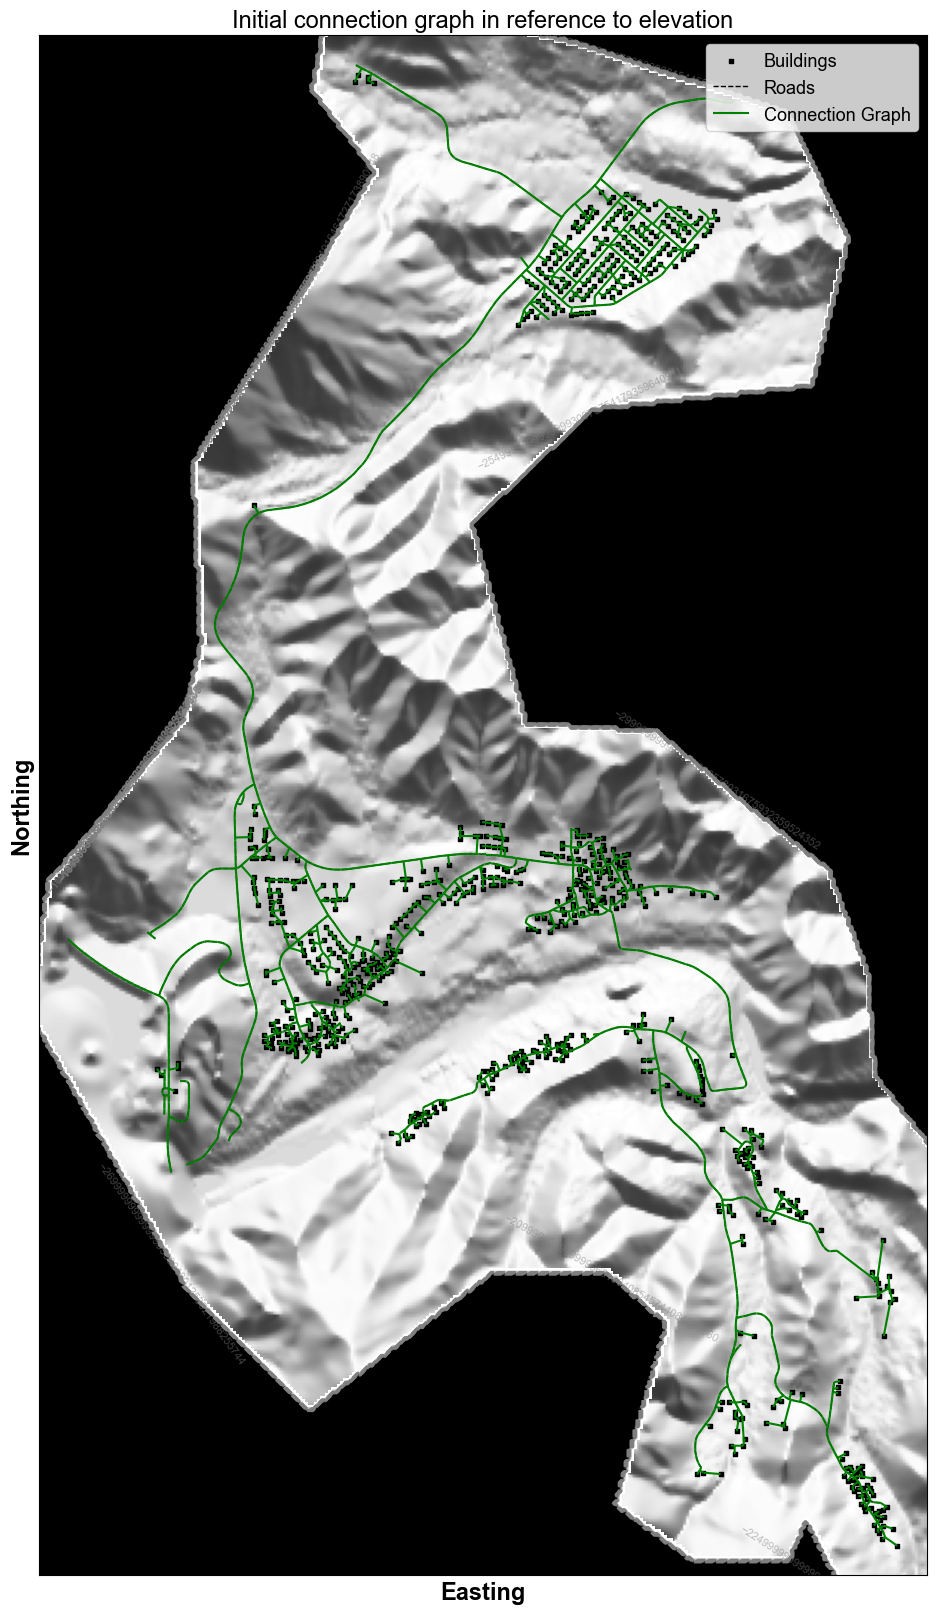

In [9]:
# Plot of the connection graph based on the initialisation of the input data. 
fig, ax = pysewer.plot_model_domain(
    test_model_domain,
    plot_connection_graph=custom_config.plotting.plot_connection_graph,
    hillshade=custom_config.plotting.hillshade,
)
ax.set_title("Initial connection graph in reference to elevation")

In [10]:
# preview the the buildings geoDataFrame
test_model_domain.buildings.get_gdf().head()


,OID_,Name,FolderPath,SymbolID,AltMode,Base,Snippet,PopupInfo,HasLabel,LabelID,...,NEAR_FID,NEAR_DIST,NEAR_X,NEAR_Y,POINT_X,POINT_Y,geometry,nearest_point,distance,cluster
0,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,108,24.984560,689738.466001,2.554467e+06,689713.6976,2.554464e+06,POINT (689713.698 2554463.950),POINT (689738.4660005865 2554467.229613401),24.98456,0
1,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,108,17.414640,689743.517334,2.554438e+06,689726.4170,2.554435e+06,POINT (689726.417 2554434.914),POINT (689743.5173340624 2554438.207370942),17.41464,0
2,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,142,10.155101,689724.692601,2.554415e+06,689729.2341,2.554405e+06,POINT (689729.234 2554405.482),POINT (689724.692600878 2554414.564998248),10.155101,0
3,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,107,16.089287,689729.748675,2.554375e+06,689743.8734,2.554382e+06,POINT (689743.873 2554382.425),POINT (689729.748674614 2554374.720931018),16.089287,0
4,0,Building,Mazarih_buildings.kmz/Mazarih_buildings,0,-1,0.0,None,None,-1,0,...,107,11.837779,689723.424042,2.554386e+06,689713.0317,2.554381e+06,POINT (689713.032 2554380.648),POINT (689723.4240421752 2554386.316130646),11.837779,0


### Generate connection graph
This is the final step preprocessing where the initial graph is simplified to remove unnecessary nodes, converted to directed graph, checks for self-loops and removes them and enhances the nodes and edges by setting hydraulic elements of the network. 

In [11]:
# create the the graph conections
# this to be used for the routing algorithm
connection_graph = test_model_domain.generate_connection_graph()

3431
1452
Simplified graph: 3431 to 1427 nodes, 3958 to 1953 edges


In [12]:
# get the sinks within the area of interest. 
# verify that the sinks were addeded
test_model_domain.get_sinks()

[(691258.1220546402, 2554226.804832181), (690500.0, 2557000.0)]

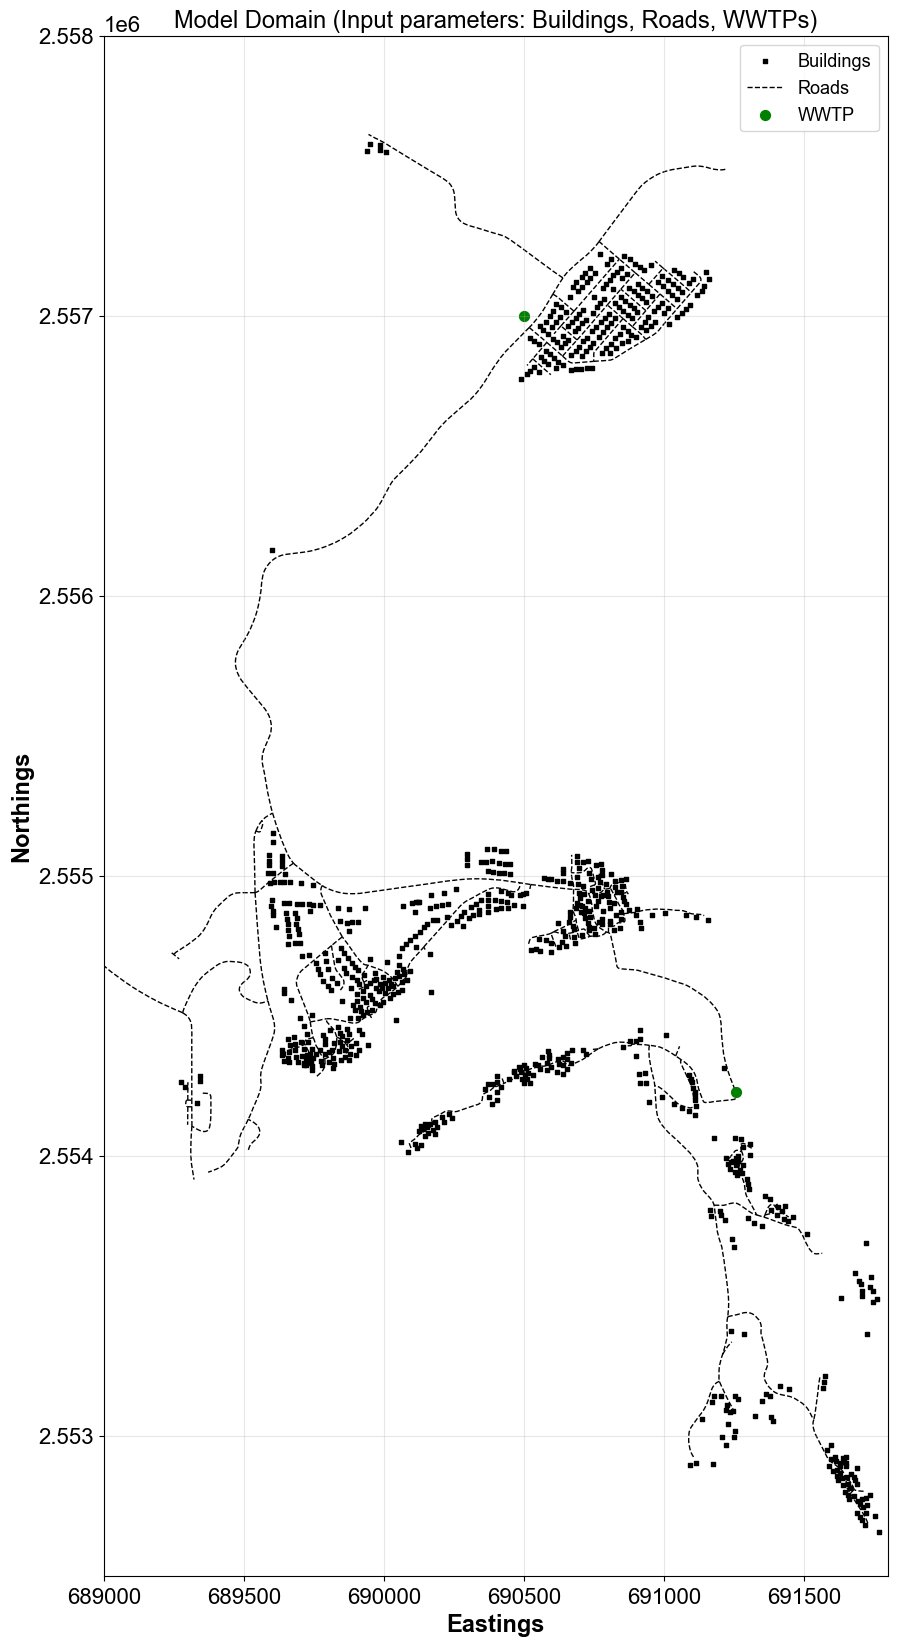

In [13]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sink=custom_config.plotting.plot_sink, 
)
ax.set_title("Model Domain (Input parameters: Buildings, Roads, WWTPs)")
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2558000)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)

## Routing

The routing solver implements the repeated shortest path heuristic (RSPH) algorithm to create a directed steiner tree. It iteratively construct a directed tree that connects a set of terminals (e.g., buildings) to a designated sink (e.g., a wastewater treatment plant).

In [14]:
# Generate optimal sewer layout 
layout = pysewer.rsph_tree(connection_graph, test_model_domain.get_sinks(), "building")

Number of weakly connected components: 1
Number of terminals (buildings) to process: 800
Number of nodes in final sewer graph: 1427
Number of edges in final sewer graph: 1388


No pumping station in the sewer graph
Plotting sewer graph without pumping station


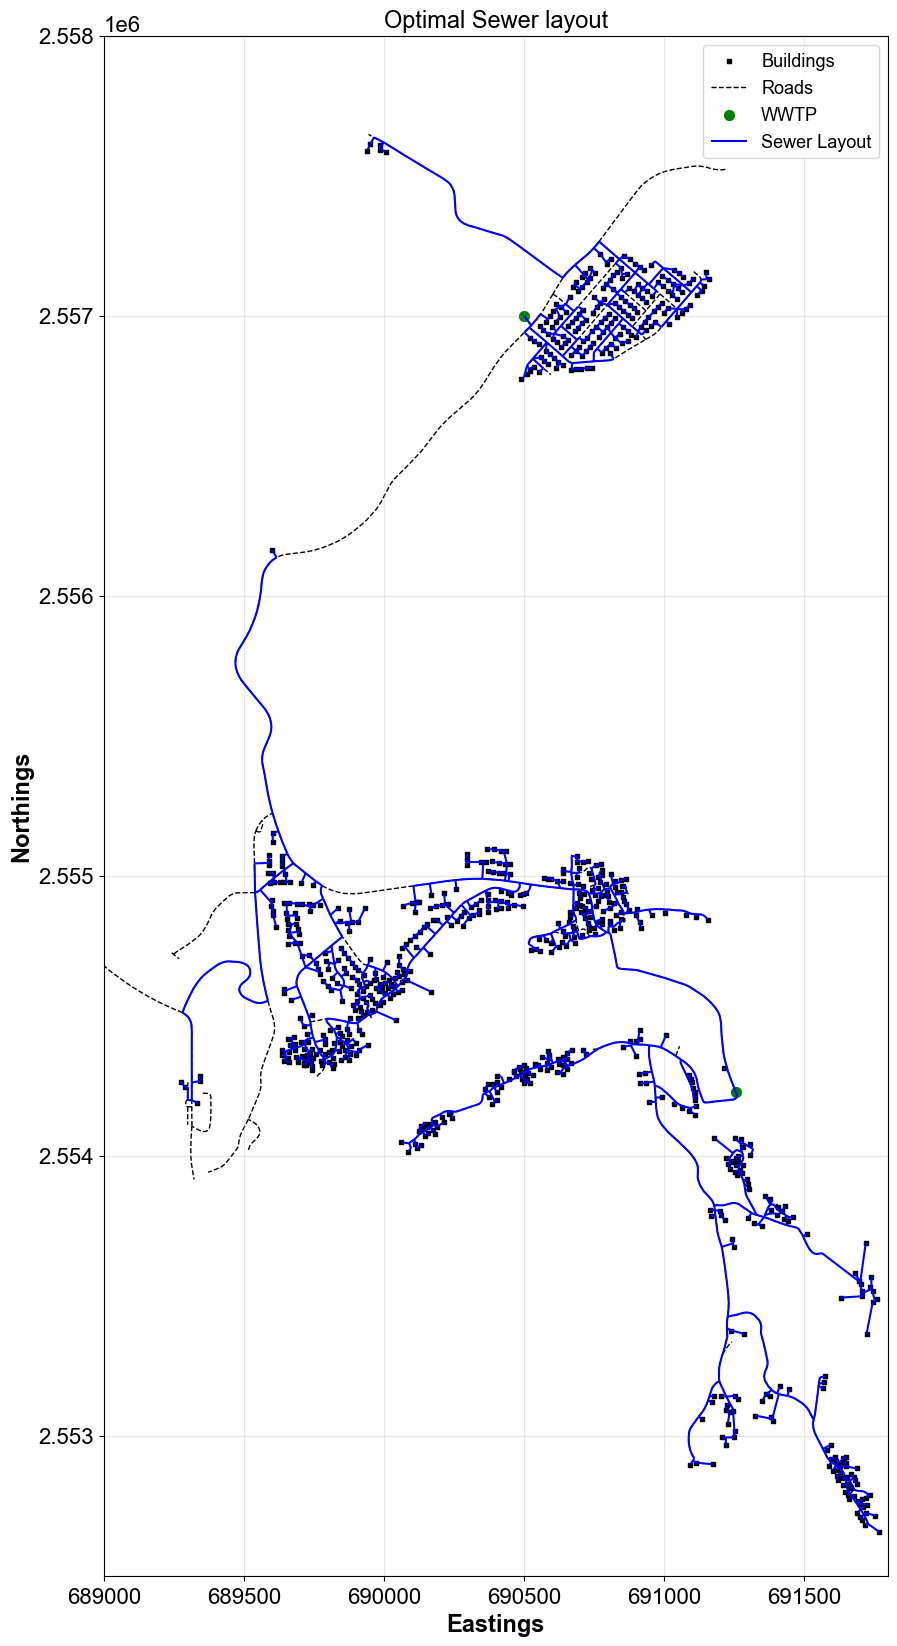

In [15]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=layout, plot_sink=True
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2558000)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.set_title("Optimal Sewer layout")
ax.grid(alpha=0.3)
plt.show()

## Hydraulic Design and Optimization

The purpose of this stage of generating the sewer network layout is to create a hydraulic-optimised layout. 
Here, the hydraulic-optimised layout is gravity-prioritised which limits the number of pumps in the final layout. 
Two key methods are employed here: 
1. Flow estimation, to determine the capacity needs of the sewer network and, 
2. Calculation of the hydraulic parameters, which covers the placement of pumps and sizing of the pipe diameters.


### Decision variables:
- pipe diameters: diameters selected based hydraulic capacity
- pipe slopes: determines whether pipe sections are gravity-prioritised or not. 
- pump penalty: a cost factor used to quantify the economic impacts of using pumps in the network.

### Constraints:
- hydraulic capacity: ensures that the flow rate in the pipes does not exceed the maximum capacity (peak flow)
- trench depth (tmin and tmax): ensures the pipes are deep enough but not too deep to avoid excessive costs.

The table below shows the hydraulic constraints and the parameters used in the optimization process.

| Constraint                      | Parameter                 | Value/Condition                      | Description                                                                        |
| ------------------------------- | ------------------------- | ------------------------------------ | ---------------------------------------------------------------------------------- |
| **Minimum Slope**               | `min_slope`               | -0.01                                | The minimum slope required for gravitational flow.                                 |
| **Maximum Trench Depth**        | `tmax`                    | 8 (m)                                | Maximum allowable trench depth to ensure cover and structural integrity.           |
| **Minimum Trench Depth**        | `tmin`                    | 0.25 (m)                             | Minimum trench depth to ensure adequate hydraulic flow.                            |
| **Inflow Trench Depth**         | `inflow_trench_depth`     | 0  (m)                               | Trench depth at the inflow point, used for initial calculations.                   |
| **Pipe Roughness**              | `roughness`               | 0.013 (s/m^{1/3})                    | Roughness coefficient of the pipes, affecting flow calculations.                   |
| **Pressurized Diameter**        | `pressurized_diameter`    | 0.2 (m)                              | Diameter of pipes when pressurized                                                 |
| **Available Diameters**         | `diameters`               | [0.1, 0.15, 0.2, 0.25, 0.3, 0.4] (m) | List of available pipe diameters for use in the network.                           |
| **Peak Factor**                 | `peak_factor`             | 2.3                                  | Multiplier to adjust calculated flow rates to account for peak times.              |
| **Inhabitants per Dwelling**    | `inhabitants_dwelling`    | 3                                    | Number of inhabitants per dwelling unit, used for wastewater generation estimates. |
| **Daily Wastewater per Person** | `daily_wastewater_person` | 0.2 (m³)                             | Daily wastewater output per person, essential for flow calculations.               |


### Objective Function:
Minimize the total cost of the sewer network, defined by the equation:

$$
Z = \sum_{i=1}^{n} (C_{\text{trench}, i} + C_{\text{pipe}, i}) + \sum_{j=1}^{m} C_{\text{pump}, j} + \lambda \cdot N_{\text{pumps}}
$$

Where:

- $ Z $ is the total cost of the sewer network.
- $ n $ is the number of pipe segments.
- $ m $ is the number of pumps.
- $C_{\text{trench}, i}$ is the trenching cost for pipe segment \( i \), calculated as $( c_{\text{trench}} \times d_i \times l_i)$.
- $C_{\text{pipe}, i}$ is the cost of the pipe for segment \( i \), calculated as $( c_{\text{pipe}} \times l_i)$.
- $C_{\text{pump}, j}$ is the base cost for installing and operating pump j.
- $ N_{\text{pumps}}$ is the total number of pumps
- $ \lambda $ is the pump penalty factor.

**Note:** The term "cost" in the objective function is used figuratively to represent a composite measure of various factors such as construction efforts, 
operational demands, and environmental impacts. It does not directly equate to monetary value but is a conceptual metric used to evaluate and minimize 
the overall resource expenditure of the sewer network design.


The location and the number of the pump is optimized through the setting of the pump penalty. By setting a high penalty, the design algorithm is encouraged 
to find solutions that rely on natural gravity flow and, therefore, avoid using pumps unless absolutely necessary. 
In addition, In order to decrease the number of pumps, the max. trench depth can be increased. However, this will result in overall higher costs associated with
the network. 
When a house is located deeper than the network itself, a private pump is set. The main difference between the private pump and pump station is,
that the private pump only deals with the water from that certain household (Average PE number per buildings), 
while pump station may be designed to convey the water from upstream network sections.

0


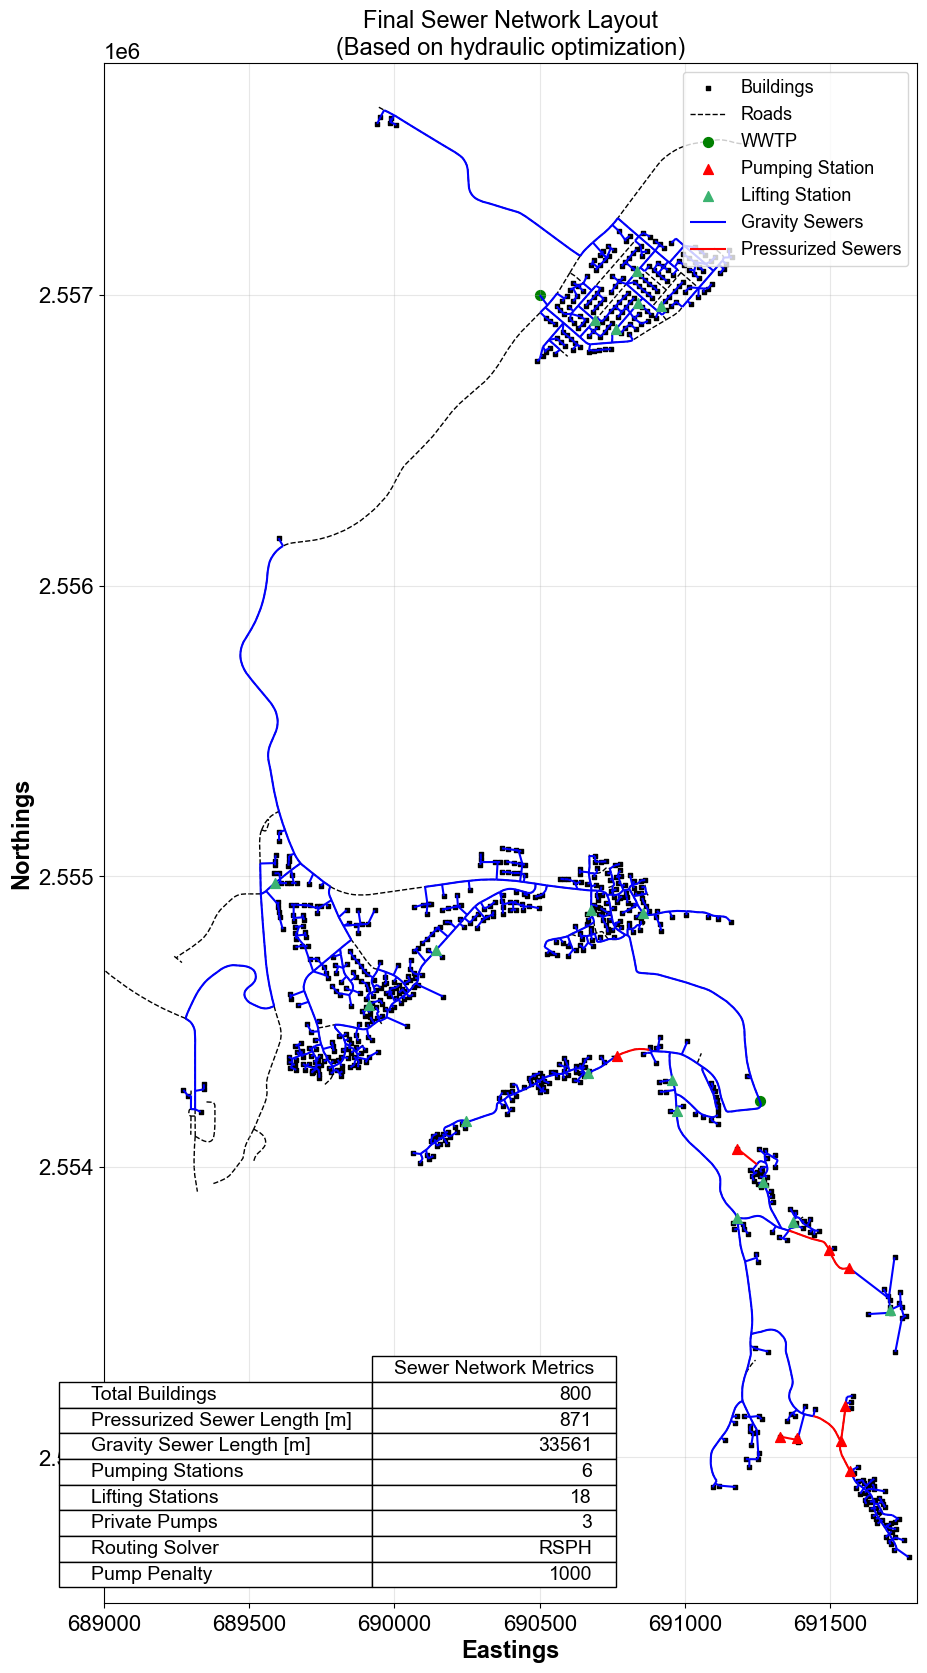

In [16]:
G = pysewer.estimate_peakflow(
    layout,
    inhabitants_dwelling=custom_config.optimization.inhabitants_dwelling,
    daily_wastewater_person=custom_config.optimization.daily_wastewater_person,
)
G = pysewer.calculate_hydraulic_parameters(
    layout,
    sinks=test_model_domain.get_sinks(),
    diameters=custom_config.optimization.diameters,
    pressurized_diameter=custom_config.optimization.pressurized_diameter,
    include_private_sewer=True,
    roughness=custom_config.optimization.roughness,
)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=G, info_table=info, plot_sink=True
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)

ax.set_title("Final Sewer Network Layout\n(Based on hydraulic optimization)")
plt.legend(loc="upper right")
plt.show()
# adjust the figure size 
fig.set_size_inches(20, 20)
fig.savefig("../data/figures/optimised_sewer_layout.svg", transparent=True, bbox_inches="tight")

In [17]:
# get the info of the sewer network
info = pysewer.get_sewer_info(G)
info

{'Total Buildings': 800,
 'Pressurized Sewer Length [m]': 871,
 'Gravity Sewer Length [m]': 33561,
 'Pumping Stations': 6,
 'Lifting Stations': 18,
 'Private Pumps': 3}

### Peak flow estimation
The peak flow was estimated as the dry weather peak flow in accordance with (Tchobanoglous et al., 2003). 
The current peak flow is estimated as 2x hourly average flow (m3/s). The peak flow factor was selected as 2, however it can be changed by the user. 

Reference: Tchobanoglous, G., Burton, F. L., Stensel, H. D., & Metcalf & Eddy (Eds.). (2003). Wastewater engineering: Treatment and reuse (4th ed). McGraw-Hill.

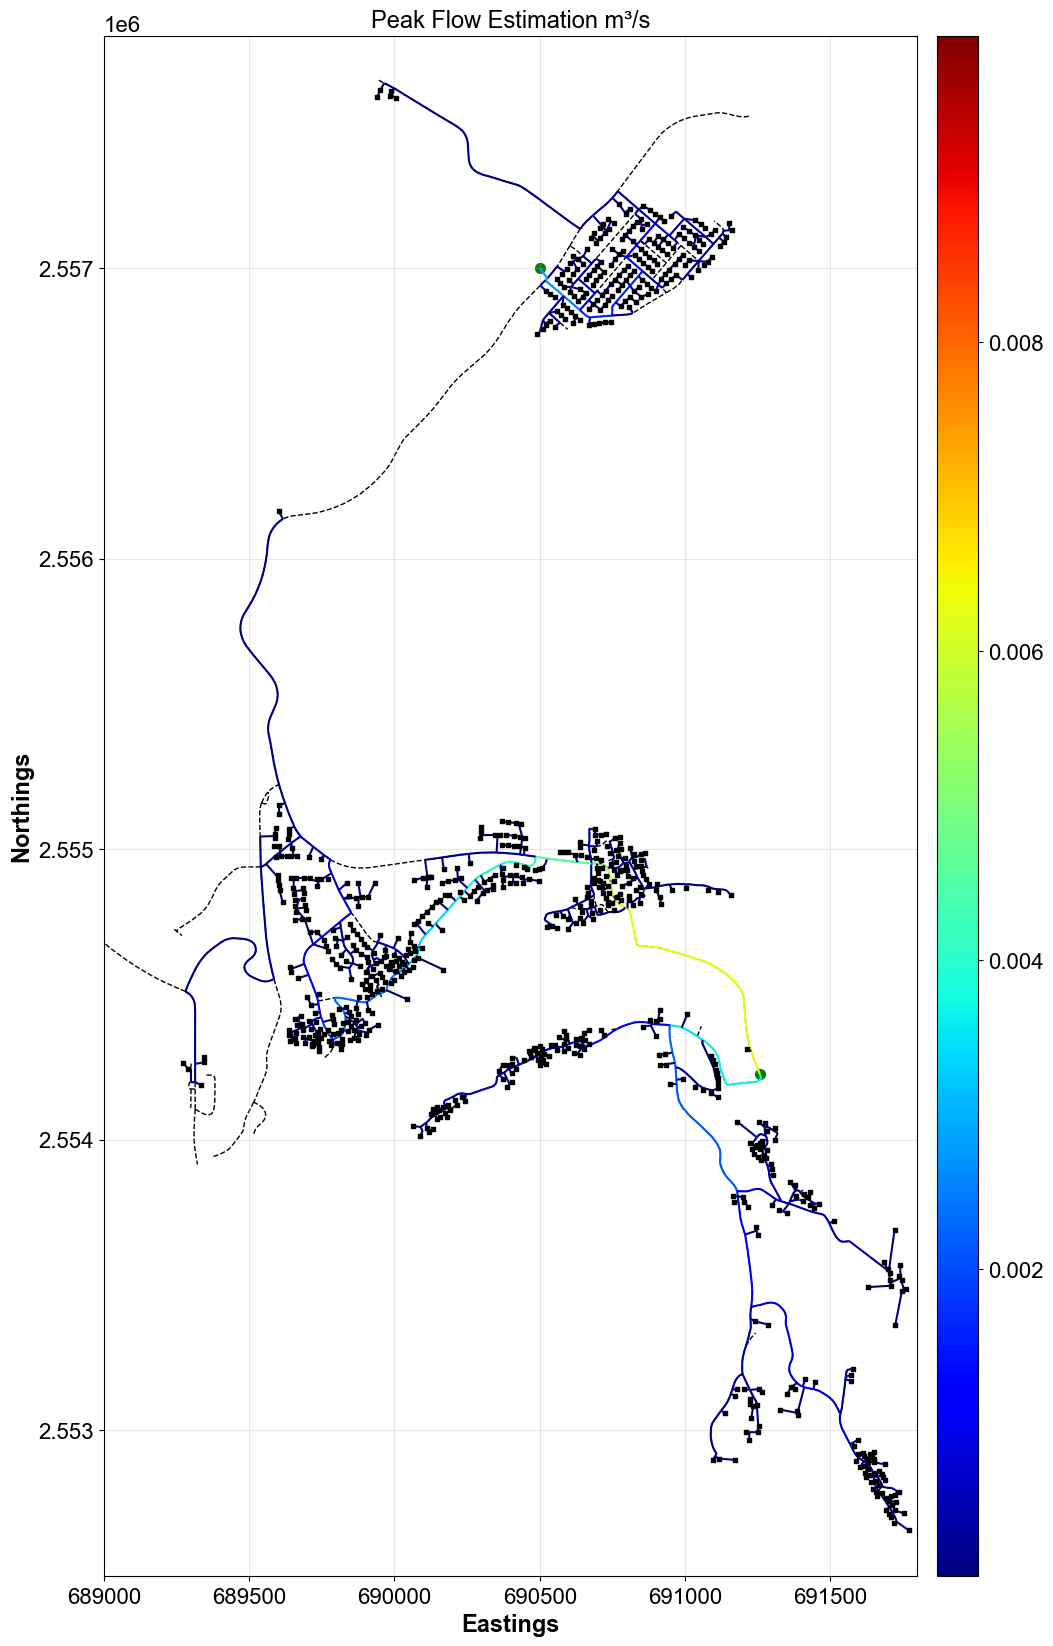

In [18]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="peak_flow", title="Peak Flow Estimation m³/s", plot_sink=True
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()

### Pipe diameter
The pipe diameter was selected per section (between manholes) depending on the slope of the section and the cumulative number of PE 
(PE connected to that section plus the number of PE that are connected upstream) in accordance with (Tchobanoglous et al., 2003).

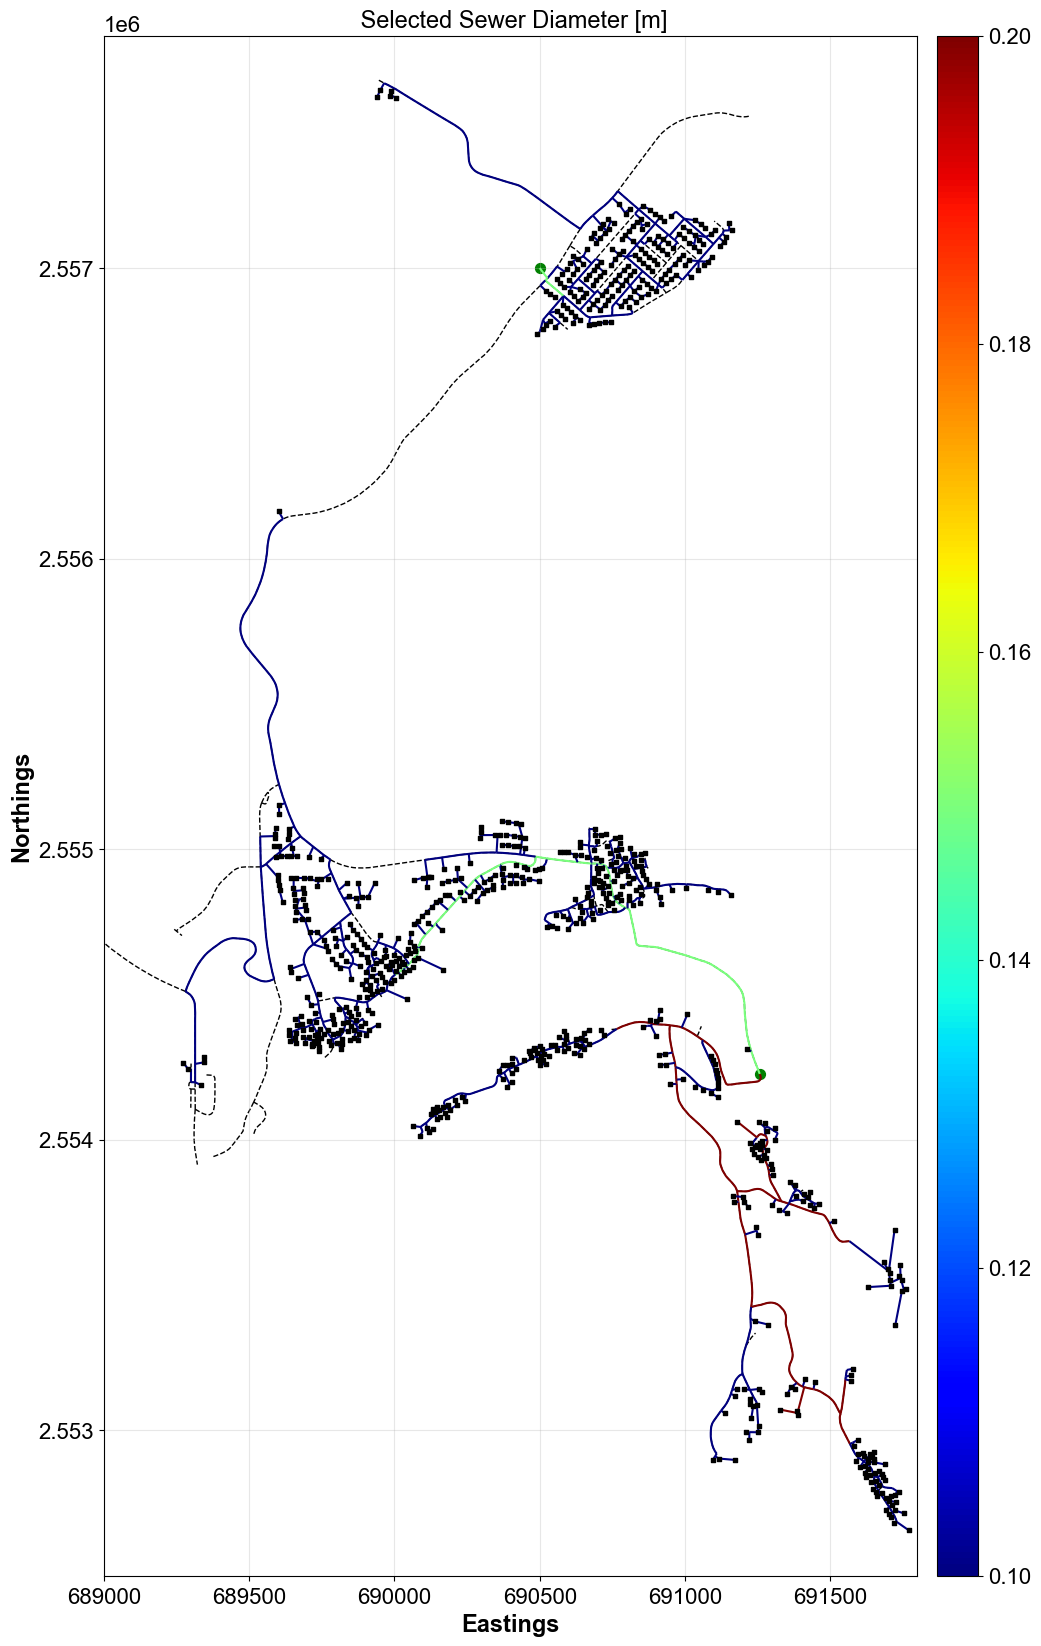

In [19]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="diameter", title=" Selected Sewer Diameter [m]", plot_sink=True
)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()

## Export Sewer Network

The sewer network is exported as a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.


In [20]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
pysewer.export_sewer_network(sewer_network_gdf, "sewer_network.gpkg")

Successfully exported sewer network to sewer_network.gpkg.


In [21]:
# check the file that was created 
import geopandas as gpd
sn_gdf = gpd.read_file("sewer_network.gpkg")
sn_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   distance              1388 non-null   float64 
 1   profile               1388 non-null   object  
 2   needs_pump            1388 non-null   object  
 3   weight                1388 non-null   float64 
 4   pressurized           1388 non-null   object  
 5   trench_depth_profile  1388 non-null   object  
 6   mean_td               1388 non-null   float64 
 7   diameter              1388 non-null   float64 
 8   peak_flow             1388 non-null   float64 
 9   edge_counter          1388 non-null   int64   
 10  OBJECTID              26 non-null     float64 
 11  SUBTYPELBL            1388 non-null   object  
 12  ROADNAMEA             1371 non-null   object  
 13  ROADNAMEE             1371 non-null   object  
 14  ROADNO                26 non-null     float64 
 

In [22]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
sewer_network_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              1388 non-null   geometry
 1   distance              1388 non-null   float64 
 2   profile               1388 non-null   object  
 3   needs_pump            1388 non-null   bool    
 4   weight                1388 non-null   float64 
 5   pressurized           1388 non-null   bool    
 6   trench_depth_profile  1388 non-null   object  
 7   mean_td               1388 non-null   float64 
 8   diameter              1388 non-null   float64 
 9   peak_flow             1388 non-null   float64 
 10  edge_counter          1388 non-null   int64   
 11  OBJECTID              26 non-null     float64 
 12  SUBTYPELBL            26 non-null     object  
 13  ROADNAMEA             9 non-null      object  
 14  ROADNAMEE             9 non-null      object  
 

In [23]:
# try using geoparquet to save the geodataframe
sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)

/var/folders/ft/8qzbkr994y9gmhkqb5l97lsw0000gq/T/ipykernel_1630/1793822407.py:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)


In [24]:
test_parq = gpd.read_parquet("sewer_parq.parquet")
test_parq.info()
test_parq

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              1388 non-null   geometry
 1   distance              1388 non-null   float64 
 2   profile               1388 non-null   object  
 3   needs_pump            1388 non-null   bool    
 4   weight                1388 non-null   float64 
 5   pressurized           1388 non-null   bool    
 6   trench_depth_profile  1388 non-null   object  
 7   mean_td               1388 non-null   float64 
 8   diameter              1388 non-null   float64 
 9   peak_flow             1388 non-null   float64 
 10  edge_counter          1388 non-null   int64   
 11  OBJECTID              26 non-null     float64 
 12  SUBTYPELBL            26 non-null     object  
 13  ROADNAMEA             9 non-null      object  
 14  ROADNAMEE             9 non-null      object  
 

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,edge_counter,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,private_sewer
0,"LINESTRING (691331.435 2553788.287, 691320.033...",20.134885,"[[0.0, 127.91], [10.0, 127.53], [20.0, 127.29]...",False,20.134885,False,"[[0.0, 121.0245661286283], [10.0, 120.92456612...",6.605771,0.2,0.000783,1000,NaN,None,None,None,NaN,NaN,NaN,None
1,"LINESTRING (691357.594 2553780.200, 691331.435...",27.380986,"[[0.0, 127.13], [10.0, 127.33], [20.0, 127.33]...",False,27.380986,False,"[[0.0, 121.46418046388283], [10.0, 121.3641804...",6.104272,0.2,0.000415,987,8696.0,WAY,شارع الظاهر,al Dhahir Street,0.0,292.3177,292.272612,None
2,"LINESTRING (691497.051 2553712.087, 691493.035...",161.363742,"[[0.0, 119.45], [10.0, 122.35], [20.0, 121.28]...",True,161363.742332,True,"[[0.0, 0.25], [161.36374233157446, 0.25]]",120.650000,0.2,0.000224,973,NaN,None,None,None,NaN,NaN,NaN,None
3,"LINESTRING (691565.568 2553651.218, 691547.448...",103.527884,"[[0.0, 113.2], [10.0, 113.57], [20.0, 113.99],...",True,103527.883857,True,"[[0.0, 0.25], [103.5278838566126, 0.25]]",113.135000,0.2,0.000208,951,NaN,None,None,None,NaN,NaN,NaN,None
4,"LINESTRING (691395.982 2553820.064, 691395.227...",14.633401,"[[0.0, 118.94], [10.0, 118.16], [14.6334005377...",False,14.633401,False,"[[0.0, 115.67094182003957], [10.0, 115.5709418...",3.114503,0.1,0.000096,880,NaN,None,None,None,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,"LINESTRING (689985.008 2557592.936, 689986.444...",3.112488,"[[0.0, 172.47], [3.1124882392481648, 173.03]]",False,3.112488,False,"[[0.0, 172.22], [3.1124882392481648, 172.18887...",0.545562,0.1,0.000016,1144,NaN,None,None,None,NaN,NaN,NaN,None
1384,"LINESTRING (689998.543 2557618.964, 690002.888...",845.262142,"[[0.0, 173.19], [10.0, 172.68], [20.0, 172.37]...",False,845.262142,False,"[[0.0, 171.25243193892874], [10.0, 171.1524319...",0.638117,0.1,0.000080,1174,NaN,None,None,None,NaN,NaN,NaN,None
1385,"LINESTRING (690006.435 2557585.302, 689986.444...",22.532219,"[[0.0, 171.99], [10.0, 172.02], [20.0, 172.47]...",False,22.532219,False,"[[0.0, 171.74], [10.0, 171.64000000000001], [2...",0.768831,0.1,0.000016,1142,NaN,None,None,None,NaN,NaN,NaN,None
1386,"LINESTRING (689986.444 2557595.698, 689998.543...",26.224587,"[[0.0, 173.03], [10.0, 173.03], [20.0, 173.02]...",False,26.224587,False,"[[0.0, 171.51467781073515], [10.0, 171.4146778...",1.693384,0.1,0.000048,1158,NaN,None,None,None,NaN,NaN,NaN,None


In [25]:
sewer_network_gdf

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,edge_counter,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,private_sewer
0,"LINESTRING (691331.435 2553788.287, 691320.033...",20.134885,"[(0.0, 127.91), (10.0, 127.53), (20.0, 127.29)...",False,20.134885,False,"[(0.0, 121.0245661286283), (10.0, 120.92456612...",6.605771,0.2,0.000783,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"LINESTRING (691357.594 2553780.200, 691331.435...",27.380986,"[(0.0, 127.13), (10.0, 127.33), (20.0, 127.33)...",False,27.380986,False,"[(0.0, 121.46418046388283), (10.0, 121.3641804...",6.104272,0.2,0.000415,987,8696.0,WAY,شارع الظاهر,al Dhahir Street,0.0,292.3177,292.272612,NaN
2,"LINESTRING (691497.051 2553712.087, 691493.035...",161.363742,"[(0.0, 119.45), (10.0, 122.35), (20.0, 121.28)...",True,161363.742332,True,"[(0, 0.25), (161.36374233157446, 0.25)]",120.650000,0.2,0.000224,973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"LINESTRING (691565.568 2553651.218, 691547.448...",103.527884,"[(0.0, 113.2), (10.0, 113.57), (20.0, 113.99),...",True,103527.883857,True,"[(0, 0.25), (103.5278838566126, 0.25)]",113.135000,0.2,0.000208,951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"LINESTRING (691395.982 2553820.064, 691395.227...",14.633401,"[(0.0, 118.94), (10.0, 118.16), (14.6334005377...",False,14.633401,False,"[(0.0, 115.67094182003957), (10.0, 115.5709418...",3.114503,0.1,0.000096,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,"LINESTRING (689985.008 2557592.936, 689986.444...",3.112488,"[(0.0, 172.47), (3.1124882392481648, 173.03)]",False,3.112488,False,"[(0.0, 172.22), (3.1124882392481648, 172.18887...",0.545562,0.1,0.000016,1144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,"LINESTRING (689998.543 2557618.964, 690002.888...",845.262142,"[(0.0, 173.19), (10.0, 172.68), (20.0, 172.37)...",False,845.262142,False,"[(0.0, 171.25243193892874), (10.0, 171.1524319...",0.638117,0.1,0.000080,1174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385,"LINESTRING (690006.435 2557585.302, 689986.444...",22.532219,"[(0.0, 171.99), (10.0, 172.02), (20.0, 172.47)...",False,22.532219,False,"[(0.0, 171.74), (10.0, 171.64000000000001), (2...",0.768831,0.1,0.000016,1142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386,"LINESTRING (689986.444 2557595.698, 689998.543...",26.224587,"[(0.0, 173.03), (10.0, 173.03), (20.0, 173.02)...",False,26.224587,False,"[(0.0, 171.51467781073515), (10.0, 171.4146778...",1.693384,0.1,0.000048,1158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
